In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

In [2]:
from lda_collapsed_gibbs import CollapsedGibbs

In [3]:
np.random.seed(1)

## Experiments with Griffiths-Steyvers square-image data generation

In [4]:
np.random.seed(1)

In [5]:
from sim_data import GriffithsSteyversSampler

In [6]:
sampler = GriffithsSteyversSampler(num_docs = 1000, words_per_doc = 100, dimension = 5, alpha = 0.1)
sampler.sample()
None

100%|██████████| 1000/1000 [00:06<00:00, 148.47it/s]


In [7]:
docs_to_display = 50

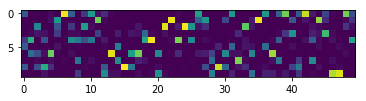

In [8]:
plt.imshow(np.array(sampler.doc_topic_mixtures)[:docs_to_display, :].T);

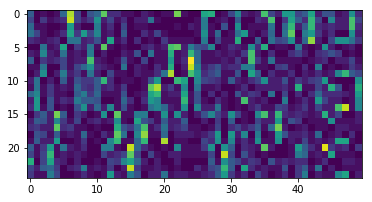

In [9]:
plt.imshow(sampler.data.toarray()[:docs_to_display, :].T);

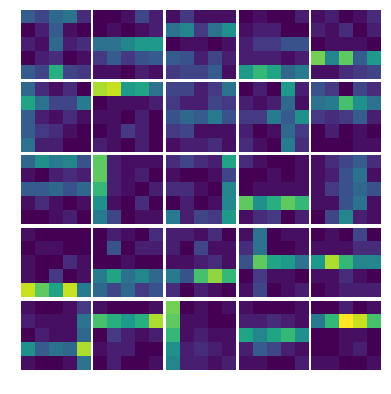

In [10]:
sq = 5
fig, ax = plt.subplots(sq, sq, figsize = (5, 5))
fig.subplots_adjust(hspace = 0.05, wspace = 0.05, left = 0, right = 1, top = 1, bottom = 0)
max_count = sampler.data[:docs_to_display, :].max()
for i in range(sq):
    for j in range(sq):
        n = i * sq + j
        if n < docs_to_display:
            X = sampler.data[n, :].toarray().reshape(sampler.dimension, sampler.dimension)
            ax[i, j].imshow(X, vmin = 0, vmax = max_count)
        ax[i, j].axis('off')

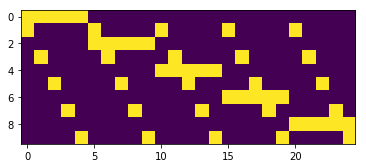

In [11]:
plt.imshow(sampler.topics);

In [12]:
np.random.seed(1)

In [13]:
result = CollapsedGibbs()
result.fit(
    corpus = sampler.gensim_corpus,
    num_topics = sampler.num_topics,
    vocab_size = sampler.vocab_size,
    num_samples = 20,
    lag = 1,
    burn_in = 10)
len(result.samples)

20

In [14]:
T = result.topics_by_sample()

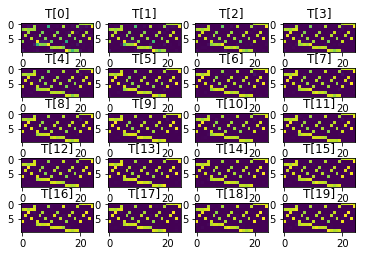

In [15]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

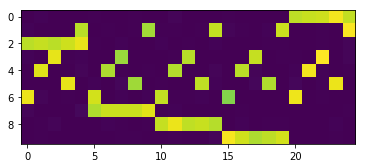

In [16]:
plt.imshow(T[-1]);

In [17]:
%%time
cooccur_by_sample = result.cooccurrence_by_sample()

CPU times: user 354 ms, sys: 16.5 ms, total: 370 ms
Wall time: 394 ms


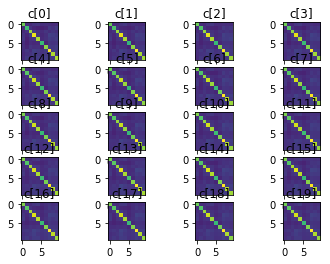

In [18]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(cooccur_by_sample[i], vmin=0)
    ax[i // nc, i % nc].set_title("c[{}]".format(i))
None

In [19]:
from sim_data import topics_griffiths_steyvers

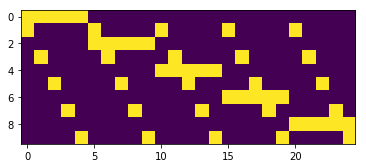

In [20]:
plt.imshow(topics_griffiths_steyvers(10));

### Try combining G.S. topics with tree-based model

In [21]:
import networkx as nx

In [22]:
from example_graphs import make_tree
from utils import nice_tree_plot, without_diag
from sim_data import HPAM2Sampler, get_alpha, topics_griffiths_steyvers
from functools import partial

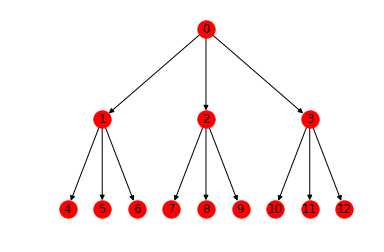

In [23]:
tree = make_tree([3,3])
nice_tree_plot(tree)

In [24]:
exact_topics = topics_griffiths_steyvers(tree.number_of_nodes())

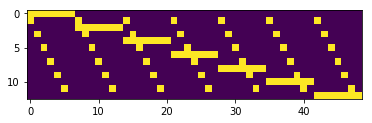

In [25]:
plt.imshow(exact_topics);

In [26]:
topic_func = lambda n: exact_topics[n, :]

In [27]:
np.random.seed(1)

In [28]:
h_sampler = HPAM2Sampler(
    tree,
    num_docs = 10000,
    words_per_doc = 1000,
    vocab_size = exact_topics.shape[1],
    topic_dirichlet = None,
    topic_func = topic_func,
    alpha_func = partial(get_alpha, scale=0.1)
)

In [29]:
h_sampler.sample();

100%|██████████| 10000/10000 [19:49<00:00,  8.40it/s]


In [30]:
tree_corpus = []
for doc in h_sampler.docs:
    ctr = Counter(doc)
    doc_short = [(k, v) for k, v in ctr.items()]
    tree_corpus.append(doc_short)
len(tree_corpus)

10000

In [31]:
custom_alpha = 1.3 ** np.arange(h_sampler.g.number_of_nodes())[::-1]

#custom_alpha = np.ones(h_sampler.g.number_of_nodes())
#custom_alpha[0] = 9
#custom_alpha[[1,2,3]] = 3

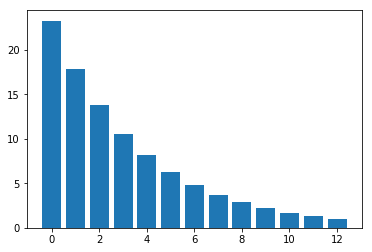

In [32]:
plt.bar(np.arange(len(custom_alpha)), custom_alpha);

In [33]:
np.random.seed(3)
# NOTE: quality of results seem to have a lot of variance (to see this, try changing the random seed)

In [34]:
result = CollapsedGibbs()
result.fit(
    corpus = tree_corpus,
    num_topics = h_sampler.g.number_of_nodes(),
    vocab_size = h_sampler.vocab_size,
    alpha = custom_alpha,
    num_samples = 20,
    lag = 1,
    burn_in = 10,
    #update_alpha_every = 1,
)
len(result.samples)

20

In [35]:
T = result.topics_by_sample()

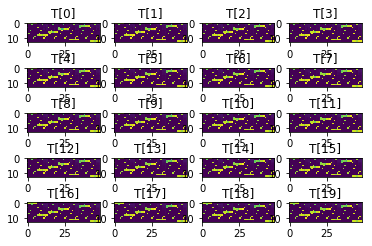

In [36]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc)
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(T[i])
    ax[i // nc, i % nc].set_title("T[{}]".format(i))
None

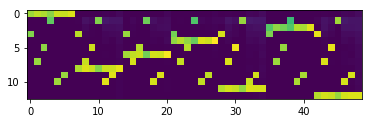

In [37]:
plt.imshow(T[-1]);

In [38]:
%%time
cooccur_by_sample = result.cooccurrence_by_sample()

CPU times: user 2.91 s, sys: 65.6 ms, total: 2.98 s
Wall time: 2.96 s


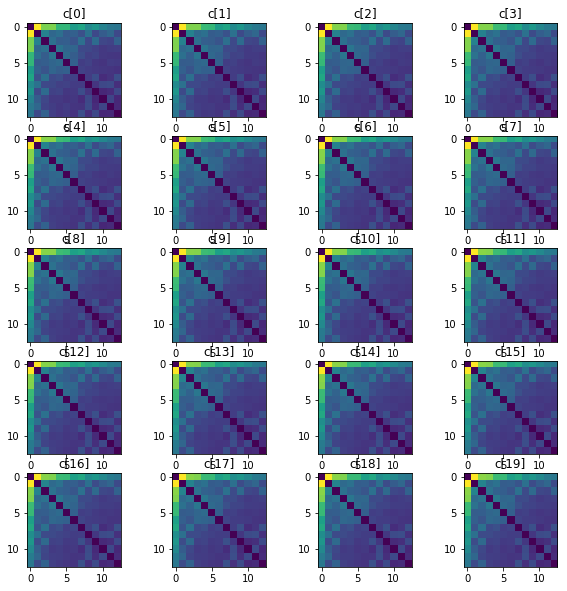

In [39]:
nr, nc = 5, 4
fig, ax = plt.subplots(nr, nc, figsize=(10,10))
for i in range(min(len(result.samples), nr * nc)):
    ax[i // nc, i % nc].imshow(without_diag(cooccur_by_sample[i]), vmin=0)
    ax[i // nc, i % nc].set_title("c[{}]".format(i))
None

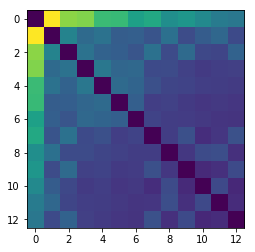

In [40]:
plt.imshow(without_diag(cooccur_by_sample[-1]), vmin=0);

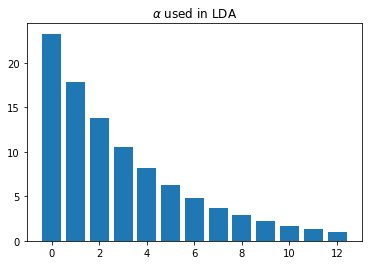

In [41]:
fig, ax = plt.subplots()
ax.bar(np.arange(result.alpha.shape[0]), result.alpha)
ax.set_title("$\\alpha$ used in LDA")
None

In [42]:
from utils import permute_square, invert_permutation

In [43]:
from tree_extraction import Aho

In [44]:
from compute_pam import compute_combo_tensor

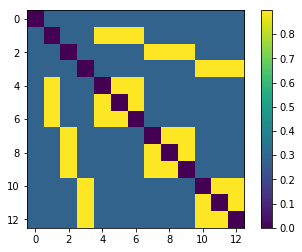

In [45]:
# True cooccurrence and ratio matrix
cooccur_true = compute_combo_tensor(g = h_sampler.g, alpha_func = partial(get_alpha, scale=0.1))

plt.imshow(without_diag(Aho.get_ratio_matrix(cooccur_true)));
plt.colorbar();

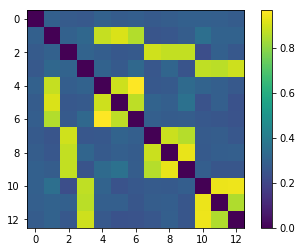

In [46]:
# Empirical cooccurrence and ratio matrix
cooccur_empirical = np.zeros(cooccur_by_sample[-1].shape)
for nodes in h_sampler.doc_nodes:
    p = np.histogram(nodes, bins = np.arange(1 + h_sampler.g.number_of_nodes()))[0]
    p = p.astype('float') / p.sum()
    cooccur_empirical += np.outer(p, p)
cooccur_empirical /= cooccur_empirical.sum()

plt.imshow(without_diag(Aho.get_ratio_matrix(cooccur_empirical)));
plt.colorbar();

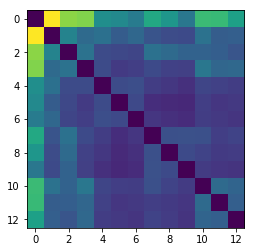

In [65]:
perm = [0, 1, 2, 3, 8, 10, 11, 7, 9, 12, 4, 5, 6]
plt.imshow(permute_square(without_diag(cooccur_by_sample[-1]), perm));

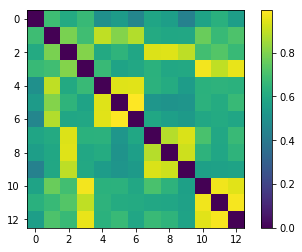

In [66]:
plt.imshow(permute_square(without_diag(Aho.get_ratio_matrix(cooccur_by_sample[-1])), perm));
plt.colorbar();

In [67]:
np.max(np.abs(cooccur_by_sample[-1] - cooccur_by_sample[-1].T))

0.0

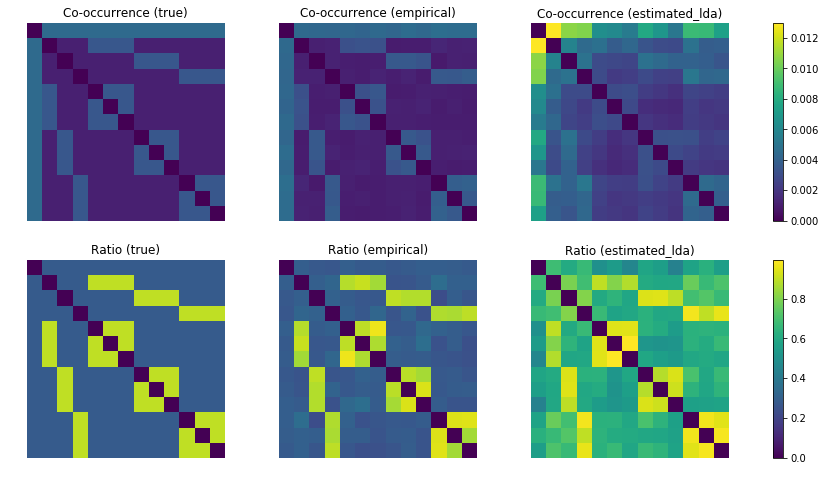

In [68]:
cooccur_all = [
    ("true", cooccur_true),
    ("empirical", cooccur_empirical),
    ("estimated_lda", permute_square(cooccur_by_sample[-1], perm=perm)),
]

ratio_all = [(name, Aho.get_ratio_matrix(m)) for name, m in cooccur_all]

max_cooccur = np.max([np.max(without_diag(m)) for name, m in cooccur_all])
max_ratio = np.max([np.max(without_diag(m)) for name, m in ratio_all])

fig, ax = plt.subplots(2, len(cooccur_all), figsize=(16, 8))
for i, (name, m) in enumerate(cooccur_all):
    ax[0, i].imshow(without_diag(m), vmin=0, vmax=max_cooccur)
    ax[0, i].set_title("Co-occurrence ({})".format(name))
    ax[0, i].axis('off')
    ax[1, i].imshow(without_diag(ratio_all[i][1]), vmin=0, vmax=max_ratio)
    ax[1, i].set_title("Ratio ({})".format(name))
    ax[1, i].axis('off')

fig.colorbar(ax[0, 0].get_images()[0], ax = [ax[0, i] for i in range(len(cooccur_all))]);
fig.colorbar(ax[1, 0].get_images()[0], ax = [ax[1, i] for i in range(len(cooccur_all))]);

In [73]:
save_matrices = False
if save_matrices:
    for name, matrix in cooccur_all:
        np.savetxt("cooccur_{}.txt".format(name), matrix, delimiter = ', ')

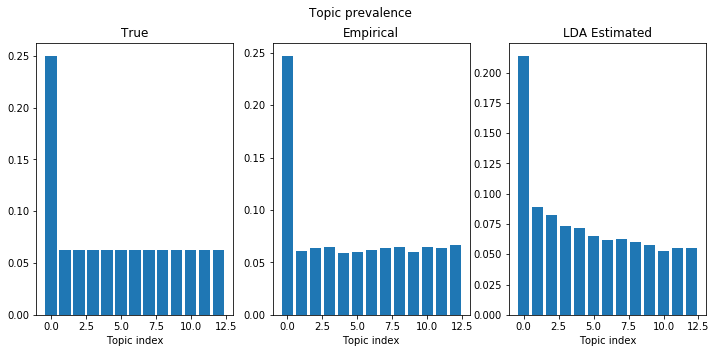

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].bar(np.arange(cooccur_true.shape[0]), cooccur_true.sum(axis=0))
ax[0].set_xlabel("Topic index")
ax[0].set_title("True")
ax[1].bar(np.arange(cooccur_true.shape[0]), cooccur_empirical.sum(axis=0))
ax[1].set_xlabel("Topic index")
ax[1].set_title("Empirical")
ax[2].bar(np.arange(cooccur_true.shape[0]), cooccur_by_sample[-1].sum(axis=0));
ax[2].set_xlabel("Topic index")
ax[2].set_title("LDA Estimated")
fig.suptitle("Topic prevalence")
None

In [52]:
true_prevalence = cooccur_true.sum(axis=0)
true_prevalence[0] / true_prevalence[1]

4.0

In [53]:
tree_extracted = Aho.extract(cooccur_by_sample[-1])

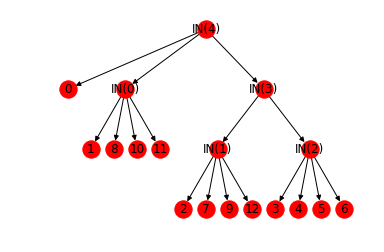

In [54]:
nice_tree_plot(tree_extracted)

In [55]:
import importlib
importlib.reload(Aho)
None

In [56]:
tree_extracted_2 = Aho.extract(cooccur_by_sample[-1], strategy='weighted')

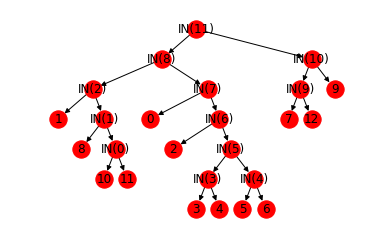

In [57]:
nice_tree_plot(tree_extracted_2)

In [58]:
r = without_diag(cooccur_by_sample[-1])
imax = np.argmax(r)
coordmax = np.unravel_index(imax, r.shape)
rmax = r[coordmax]
rmax, coordmax

(0.012986300000000063, (0, 1))

In [59]:
def diagnose_separation(cooccur, A, B, C, threshold = 0.0):
    ratio_matrix = Aho.get_ratio_matrix(cooccur)
    result = []
    for a in A:
        for b in B:
            if a == b:
                continue
            for c in C:
                if a == c or b == c:
                    continue
                strength = ratio_matrix[a, b] - max(ratio_matrix[a, c], ratio_matrix[b, c])
                if strength > 0:
                    result.append((a, b, c, strength))
    return sorted(result, key=lambda x: -x[3])

In [60]:
diagnose_separation(cooccur_by_sample[-1], [1,5,9,11], [2,6,8,12], [3,4,7,10])

[(9, 12, 10, 0.39861915174550333),
 (9, 12, 3, 0.3166790047515574),
 (11, 8, 4, 0.3133894707436048),
 (5, 6, 10, 0.3106563225825206),
 (11, 8, 7, 0.3090187350527298),
 (5, 6, 7, 0.3053330409927496),
 (9, 2, 10, 0.29738543756924174),
 (9, 12, 4, 0.2761403587610274),
 (11, 8, 3, 0.27546129272746434),
 (1, 8, 7, 0.2615277582454807),
 (9, 2, 4, 0.2509673257498146),
 (1, 8, 3, 0.21251974333314894),
 (9, 2, 3, 0.135580729176643),
 (1, 8, 4, 0.13190857934507294),
 (5, 2, 10, 0.07975233949949923),
 (1, 6, 7, 0.04348507253403078),
 (1, 2, 4, 0.026125404045002187),
 (5, 6, 3, 0.020057817388315247),
 (5, 6, 4, 0.0073520868388333716),
 (5, 8, 7, 0.006014707622216009),
 (9, 2, 7, 0.003762843242290037)]

In [61]:
import matplotlib as mpl

In [62]:
def highlight_triplet(M, i, j, k, override_title = True, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(M, **kwargs)
    results = []
    for i1, i2 in [(i, j), (j, k), (i, k)]:
        a = min(i1, i2)
        b = max(i1, i2)
        results.append((a, b, M[a, b]))
    results = sorted(results, key = lambda x: x[-1])
    for r_index, (i1, i2, Mval) in enumerate(results):
        color = 'red' if r_index == len(results) - 1 else 'white'
        ax.add_patch(mpl.patches.Rectangle(xy = (i1-0.5, i2-0.5),
            width = 1, height = 1, fill = False, edgecolor = color))
    if override_title:
        title = "Among [{}, {}, {}], max entry at ({}, {})".format(i, j, k, results[-1][0], results[-1][1])
        ax.set_title(title)

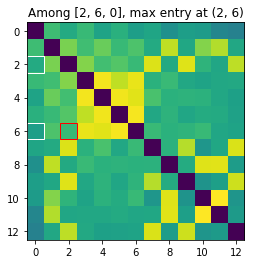

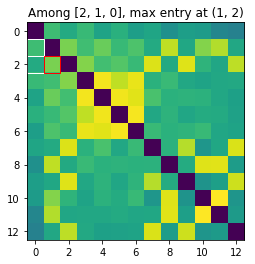

In [63]:
highlight_triplet(without_diag(Aho.get_ratio_matrix(cooccur_by_sample[-1])), 2, 6, 0)
highlight_triplet(without_diag(Aho.get_ratio_matrix(cooccur_by_sample[-1])), 2, 1, 0)

## Quick way to reload without rerunning everything

In [64]:
from importlib import reload
import sim_data
reload(sim_data)
del sim_data